In [31]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [32]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [16]:
import cv2
import numpy as np
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def extract_orb_features(image):
    orb = cv2.ORB_create(
        nfeatures=25,          
       
    )
    keypoints, descriptors = orb.detectAndCompute(image, None)
    if descriptors is None:
        descriptors = []
    return keypoints, descriptors


def extract_sift_features(image):
    sift = cv2.SIFT_create(
        nfeatures=0,          
    )
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is None:
        descriptors = []
    return keypoints, descriptors


def adjust_keypoint_size(keypoints, scale_factor):
    for kp in keypoints:
        kp.size *= scale_factor  # Scale the keypoint size
    return keypoints



def feature_extraction_function(img):
    '''
    Custom feature extraction function for image preprocessing.
    Applies Sobel filters and overlays ORB and SIFT keypoints.
    '''
    # Convert the image to uint8 format for OpenCV
    img_cv = np.uint8(img * 255)  # Tensor to uint8

    # Convert to grayscale
    gray = cv2.cvtColor(img_cv, cv2.COLOR_RGB2GRAY)

    # Apply Sobel filter (X and Y directions)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)  # X-axis
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)  # Y-axis

    # Combine Sobel results
    sobel_combined = cv2.magnitude(sobel_x, sobel_y)
    sobel_combined = np.uint8(np.clip(sobel_combined, 0, 255))

    # Convert Sobel result to BGR format for drawing keypoints
    # sobel_bgr = cv2.cvtColor(sobel_combined, cv2.COLOR_GRAY2BGR)

    # Extract ORB and SIFT features
    orb_keypoints, _ = extract_orb_features(gray)
    orb_keypoints = adjust_keypoint_size(orb_keypoints, scale_factor=0.2)

    
    sift_keypoints, _ = extract_sift_features(gray)

    # Draw keypoints on the Sobel-filtered image
    img_with_keypoints = cv2.drawKeypoints(
        sobel_combined, orb_keypoints, None, (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img_with_keypoints = cv2.drawKeypoints(
        img_with_keypoints, sift_keypoints, None, (255, 0, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    return img_with_keypoints


def create_gens(train_df, valid_df, test_df, batch_size):

    # Define model parameters
    img_size = (224, 224)
    channels = 3  # RGB channels
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended: Use custom function for test data batch size
    ts_length = len(test_df)
    test_batch_size = max(sorted(
        [ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
    test_steps = ts_length // test_batch_size

    # Define ImageDataGenerators with custom preprocessing function
    tr_gen = ImageDataGenerator(
        preprocessing_function=feature_extraction_function,
        
        horizontal_flip=True,         # Random horizontal flip
    )
    # Only preprocessing for test set
    ts_gen = ImageDataGenerator(
        preprocessing_function=feature_extraction_function)

    # Create training, validation, and test generators
    train_gen = tr_gen.flow_from_dataframe(
        train_df, x_col='filepaths', y_col='labels', target_size=img_size,
        class_mode='categorical', color_mode=color, shuffle=True, batch_size=batch_size)

    valid_gen = ts_gen.flow_from_dataframe(
        valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
        class_mode='categorical', color_mode=color, shuffle=True, batch_size=batch_size)

    # Note: we will use custom test_batch_size, and make shuffle=False
    test_gen = ts_gen.flow_from_dataframe(
        test_df, x_col='filepaths', y_col='labels', target_size=img_size,
        class_mode='categorical', color_mode=color, shuffle=False, batch_size=test_batch_size)

    return train_gen, valid_gen, test_gen

Found 3373 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.


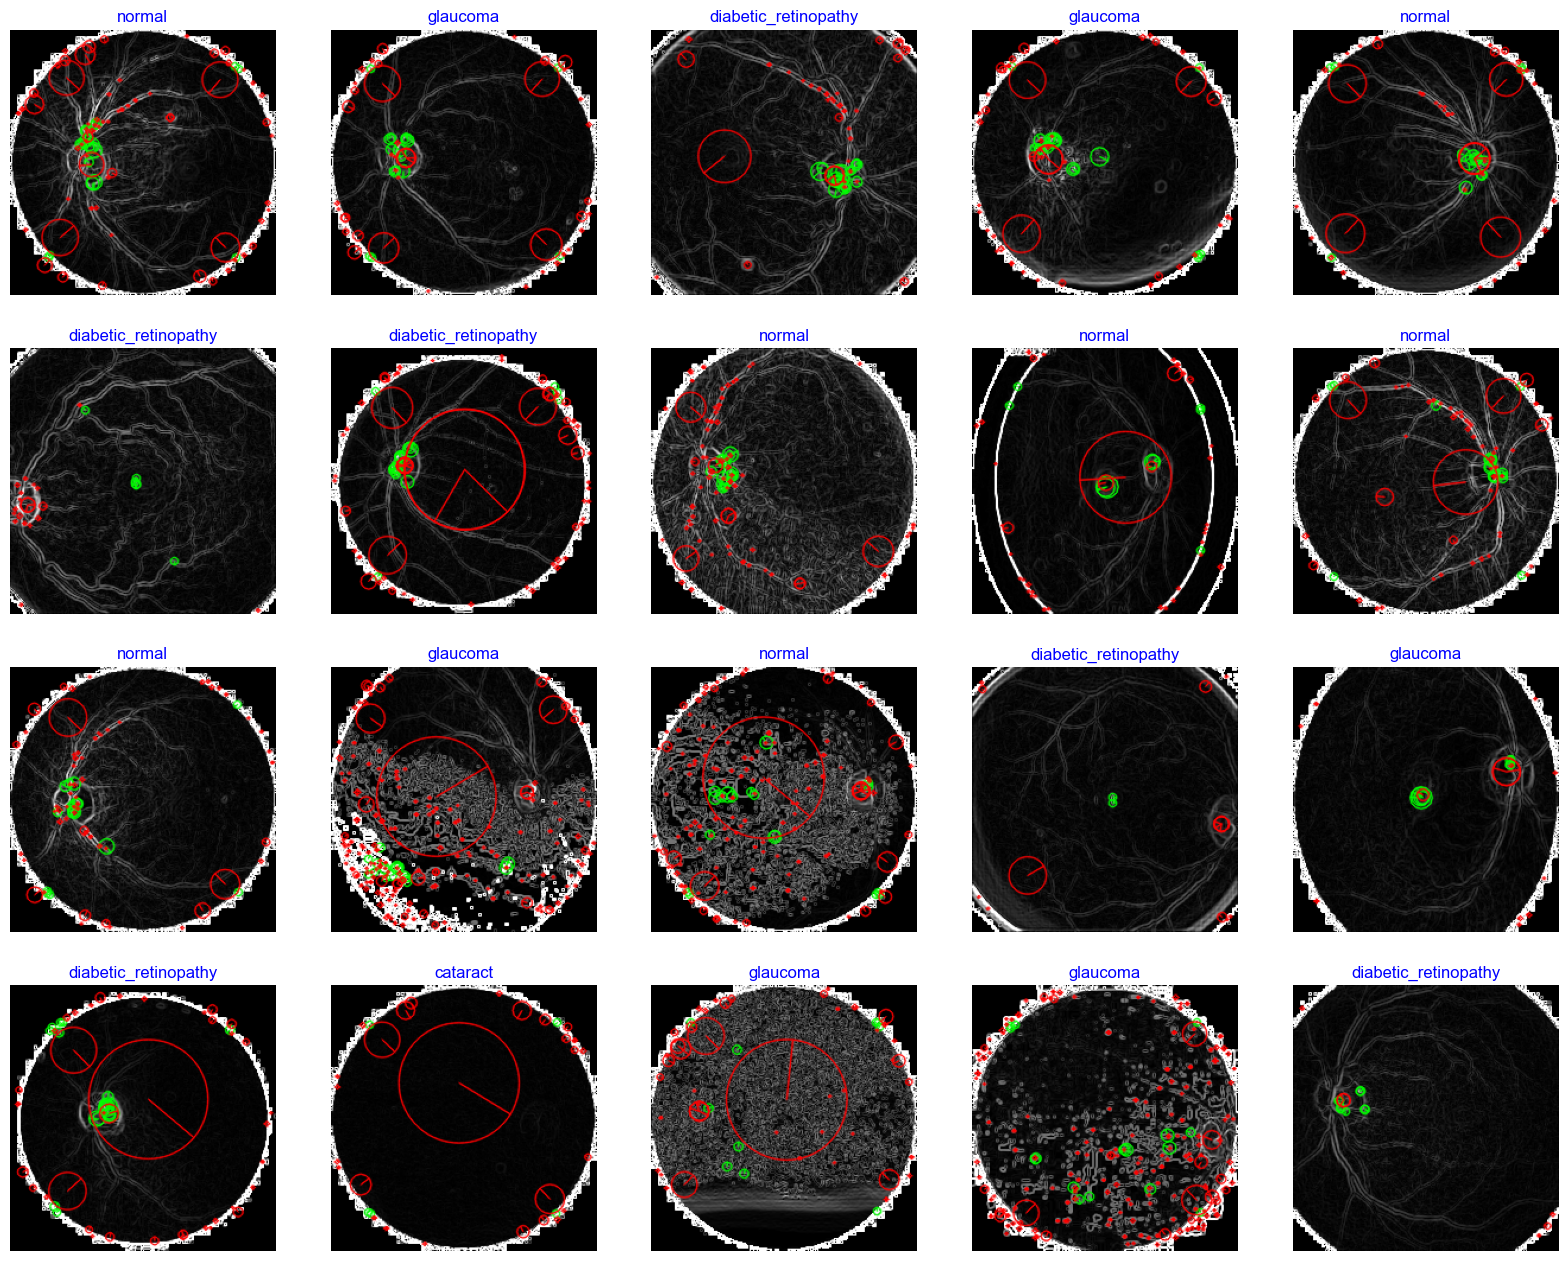

In [33]:
data_dir = 'dataset'

def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices       
    classes = list(g_dict.keys())     
    images, labels = next(gen)       

    # calculate number of displayed samples
    length = len(labels)        
    sample = min(length, 25)    

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] /255      
        plt.imshow(image)
        index = np.argmax(labels[i]) 
        class_name = classes[index]   
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()
    data_dir = 'dataset'

try:
    
    train_df, valid_df, test_df = split_data(data_dir)

    
    batch_size = 20
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

    
show_images(train_gen)

In [18]:
import tensorflow as tf
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau




# Model Definition
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create EfficientNetB3 model
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False, 
    weights="imagenet", 
    input_shape=img_shape, 
    pooling='max'
)

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, 
          kernel_regularizer=regularizers.l2(0.016), 
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), 
          activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax', dtype='float32')  
])

model.compile(
    Adamax(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitors validation loss
    factor=0.5,          # Reduce LR by half when triggered
    patience=3,          
    min_lr=1e-6          # Minimum LR to prevent overshooting
)
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)


model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 11,183,922
Trainable params: 11,093,547
Non-trainable params: 90,375
_______________________________________

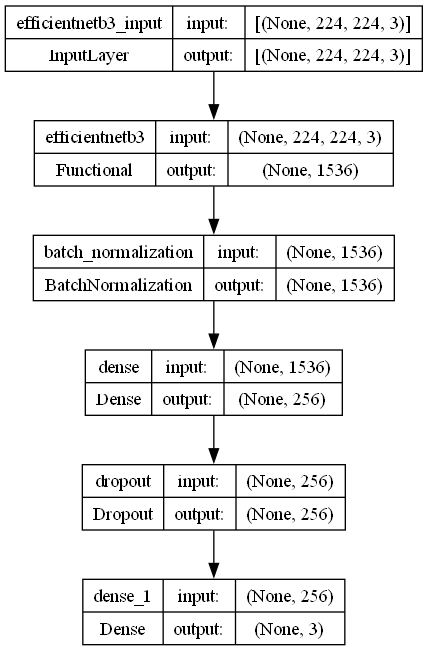

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(
    model, 
    to_file="efficientnet_model_structure.png",  # Save as an image file
    show_shapes=True,  # Show input/output shapes
    show_layer_names=True  # Show layer names
)

In [ ]:
history = model.fit(x= train_gen, epochs= 50, verbose= 1,
                     validation_data= valid_gen, validation_steps= None, shuffle= True,
                    callbacks=[early_stop,reduce_lr])

model.save('EfficientNetB33class.h5')  # Save as a .h5 file


Contain 4 class with diabetic_retinopathy class included

In [34]:
from sklearn.metrics import classification_report
import numpy as np
model = tf.keras.models.load_model("EfficientNetv2.h5")
# Evaluate the model on the test dataset (optional)
loss, accuracy = model.evaluate(test_gen)
print(f"Test Loss: {loss},Test Accuracy: {accuracy}")

# Get predictions on the test data
test_gen.reset()  # Ensure the test generator is reset
predictions = model.predict(test_gen, steps=test_gen.samples // test_gen.batch_size, verbose=1)

# Get the true labels
true_labels = test_gen.classes

# Convert the predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=test_gen.class_indices.keys())
print(report)


211/211 [==============================] - 9s 33ms/step - loss: 0.4363 - accuracy: 0.9147
Test Loss: 0.4362770617008209,Test Accuracy: 0.9146919250488281
211/211 [==============================] - 6s 24ms/step
                      precision    recall  f1-score   support

            cataract       0.93      0.95      0.94       104
diabetic_retinopathy       1.00      1.00      1.00       110
            glaucoma       0.84      0.84      0.84       101
              normal       0.88      0.86      0.87       107

            accuracy                           0.91       422
           macro avg       0.91      0.91      0.91       422
        weighted avg       0.91      0.91      0.91       422



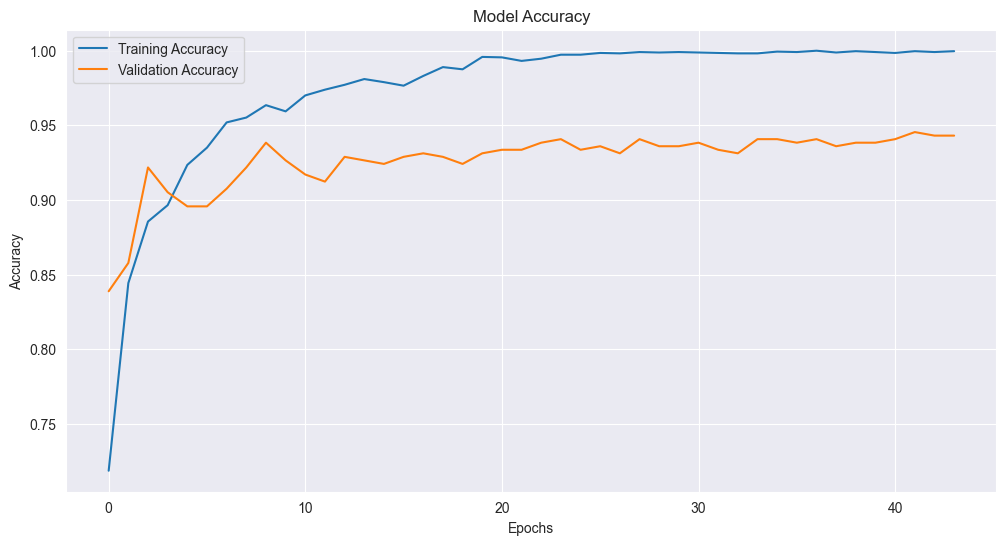

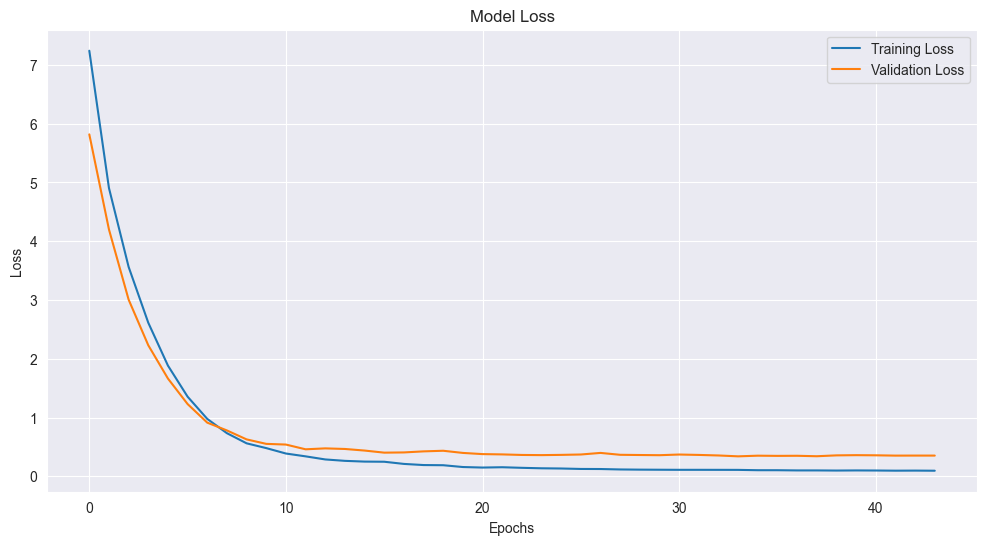

In [3]:
from IPython.display import Image, display

display(Image(filename='output.png'))
display(Image(filename='outputLoss.png'))

Contain only 3 class with diabetic_retinopathy class removed

In [13]:
from sklearn.metrics import classification_report
import numpy as np
model = tf.keras.models.load_model("EfficientNetB33class.h5")
# Evaluate the model on the test dataset (optional)
loss, accuracy = model.evaluate(test_gen)
print(f"Test Loss: {loss},Test Accuracy: {accuracy}")

# Get predictions on the test data
test_gen.reset()  # Ensure the test generator is reset
predictions = model.predict(test_gen, steps=test_gen.samples // test_gen.batch_size, verbose=1)

# Get the true labels
true_labels = test_gen.classes

# Convert the predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=test_gen.class_indices.keys())
print(report)


4/4 [==============================] - 6s 976ms/step - loss: 0.6007 - accuracy: 0.8622
Test Loss: 0.6006765365600586,Test Accuracy: 0.8621794581413269
4/4 [==============================] - 5s 803ms/step
              precision    recall  f1-score   support

    cataract       0.89      0.90      0.90       104
    glaucoma       0.82      0.83      0.83       101
      normal       0.88      0.85      0.86       107

    accuracy                           0.86       312
   macro avg       0.86      0.86      0.86       312
weighted avg       0.86      0.86      0.86       312



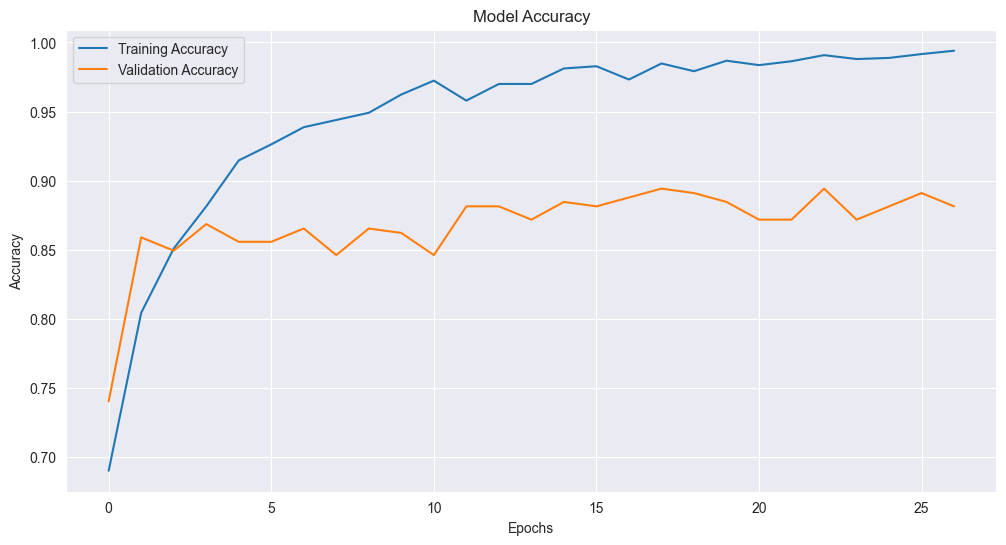

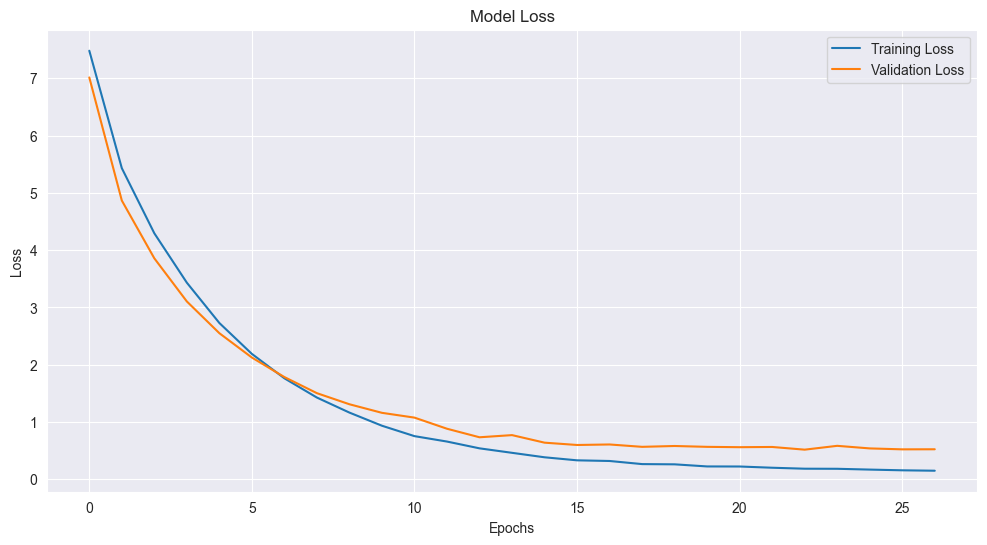

In [42]:
import pickle

# Save history after training
with open('historyB33class.pkl', 'wb') as file:
    pickle.dump(history.history, file)
# Load saved history
with open('historyB33class.pkl', 'rb') as file:
    history = pickle.load(file)

# Plot history
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
